In [2]:
import cortex

In [6]:
import nibabel as nb
from nilearn import surface
import glob
import numpy as np

import pandas as pd

In [7]:
df = []

In [8]:
for subject, session in [('bm', 'odc'),
                         ('de', 'odc1'),
                         ('eo', 'odc'),
                         ('ms', 'odc2'),
                         ('ns', 'odc'),
                         ('tr', 'odc')]:
    
    left, right = cortex.db.get_surf(f'odc.{subject}', 'fiducial')
    
    for hemi in ['lh', 'rh']:
        mask_str = 'V1{}'.format(hemi[:1])

        surfaces1 = glob.glob(f'/data/odc/derivatives/sampled_giis_cv/sub-{subject}/ses-{session}/cv/sub-{subject}_ses-{session}_cv-1_left_over_right_desc-zmap-depth-*_cv-1_hemi-{hemi}.gii')
        surfaces2 = glob.glob(f'/data/odc/derivatives/sampled_giis_cv/sub-{subject}/ses-{session}/cv/sub-{subject}_ses-{session}_cv-2_left_over_right_desc-zmap-depth-*_cv-2_hemi-{hemi}.gii')

        zmap1 = np.mean([surface.load_surf_data(s) for s in surfaces1], 0)
        zmap2 = np.mean([surface.load_surf_data(s) for s in surfaces2], 0)

        mask = cortex.utils.get_roi_verts(f'odc.{subject}', mask_str)[mask_str]
        
        if hemi == 'rh':
            mask -= len(left[0])

        zmap1 = zmap1[mask]
        zmap2 = zmap2[mask]

        nonzero_mask = ~((zmap1 == 0) | (zmap2 == 0))

        zmap1 = zmap1[nonzero_mask]
        zmap2 = zmap2[nonzero_mask]


        d = pd.DataFrame({'zmap1':zmap1, 'zmap2':zmap2, 'subject':subject, 'hemi':hemi, 'session':session})

        df.append(d)

In [9]:
df = pd.concat(df)

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
sns.set_context('poster')

In [24]:
subjects = df.subject.unique().tolist()

In [300]:
df['subject_'] = df['subject'].map(lambda s: subjects.index(s) + 1)

df['First half session'] = df['zmap1']
df['Second half session'] = df['zmap2']

In [301]:
df['Hemisphere'] = df['hemi'].map({'lh':'Left', 'rh':'Right'})

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


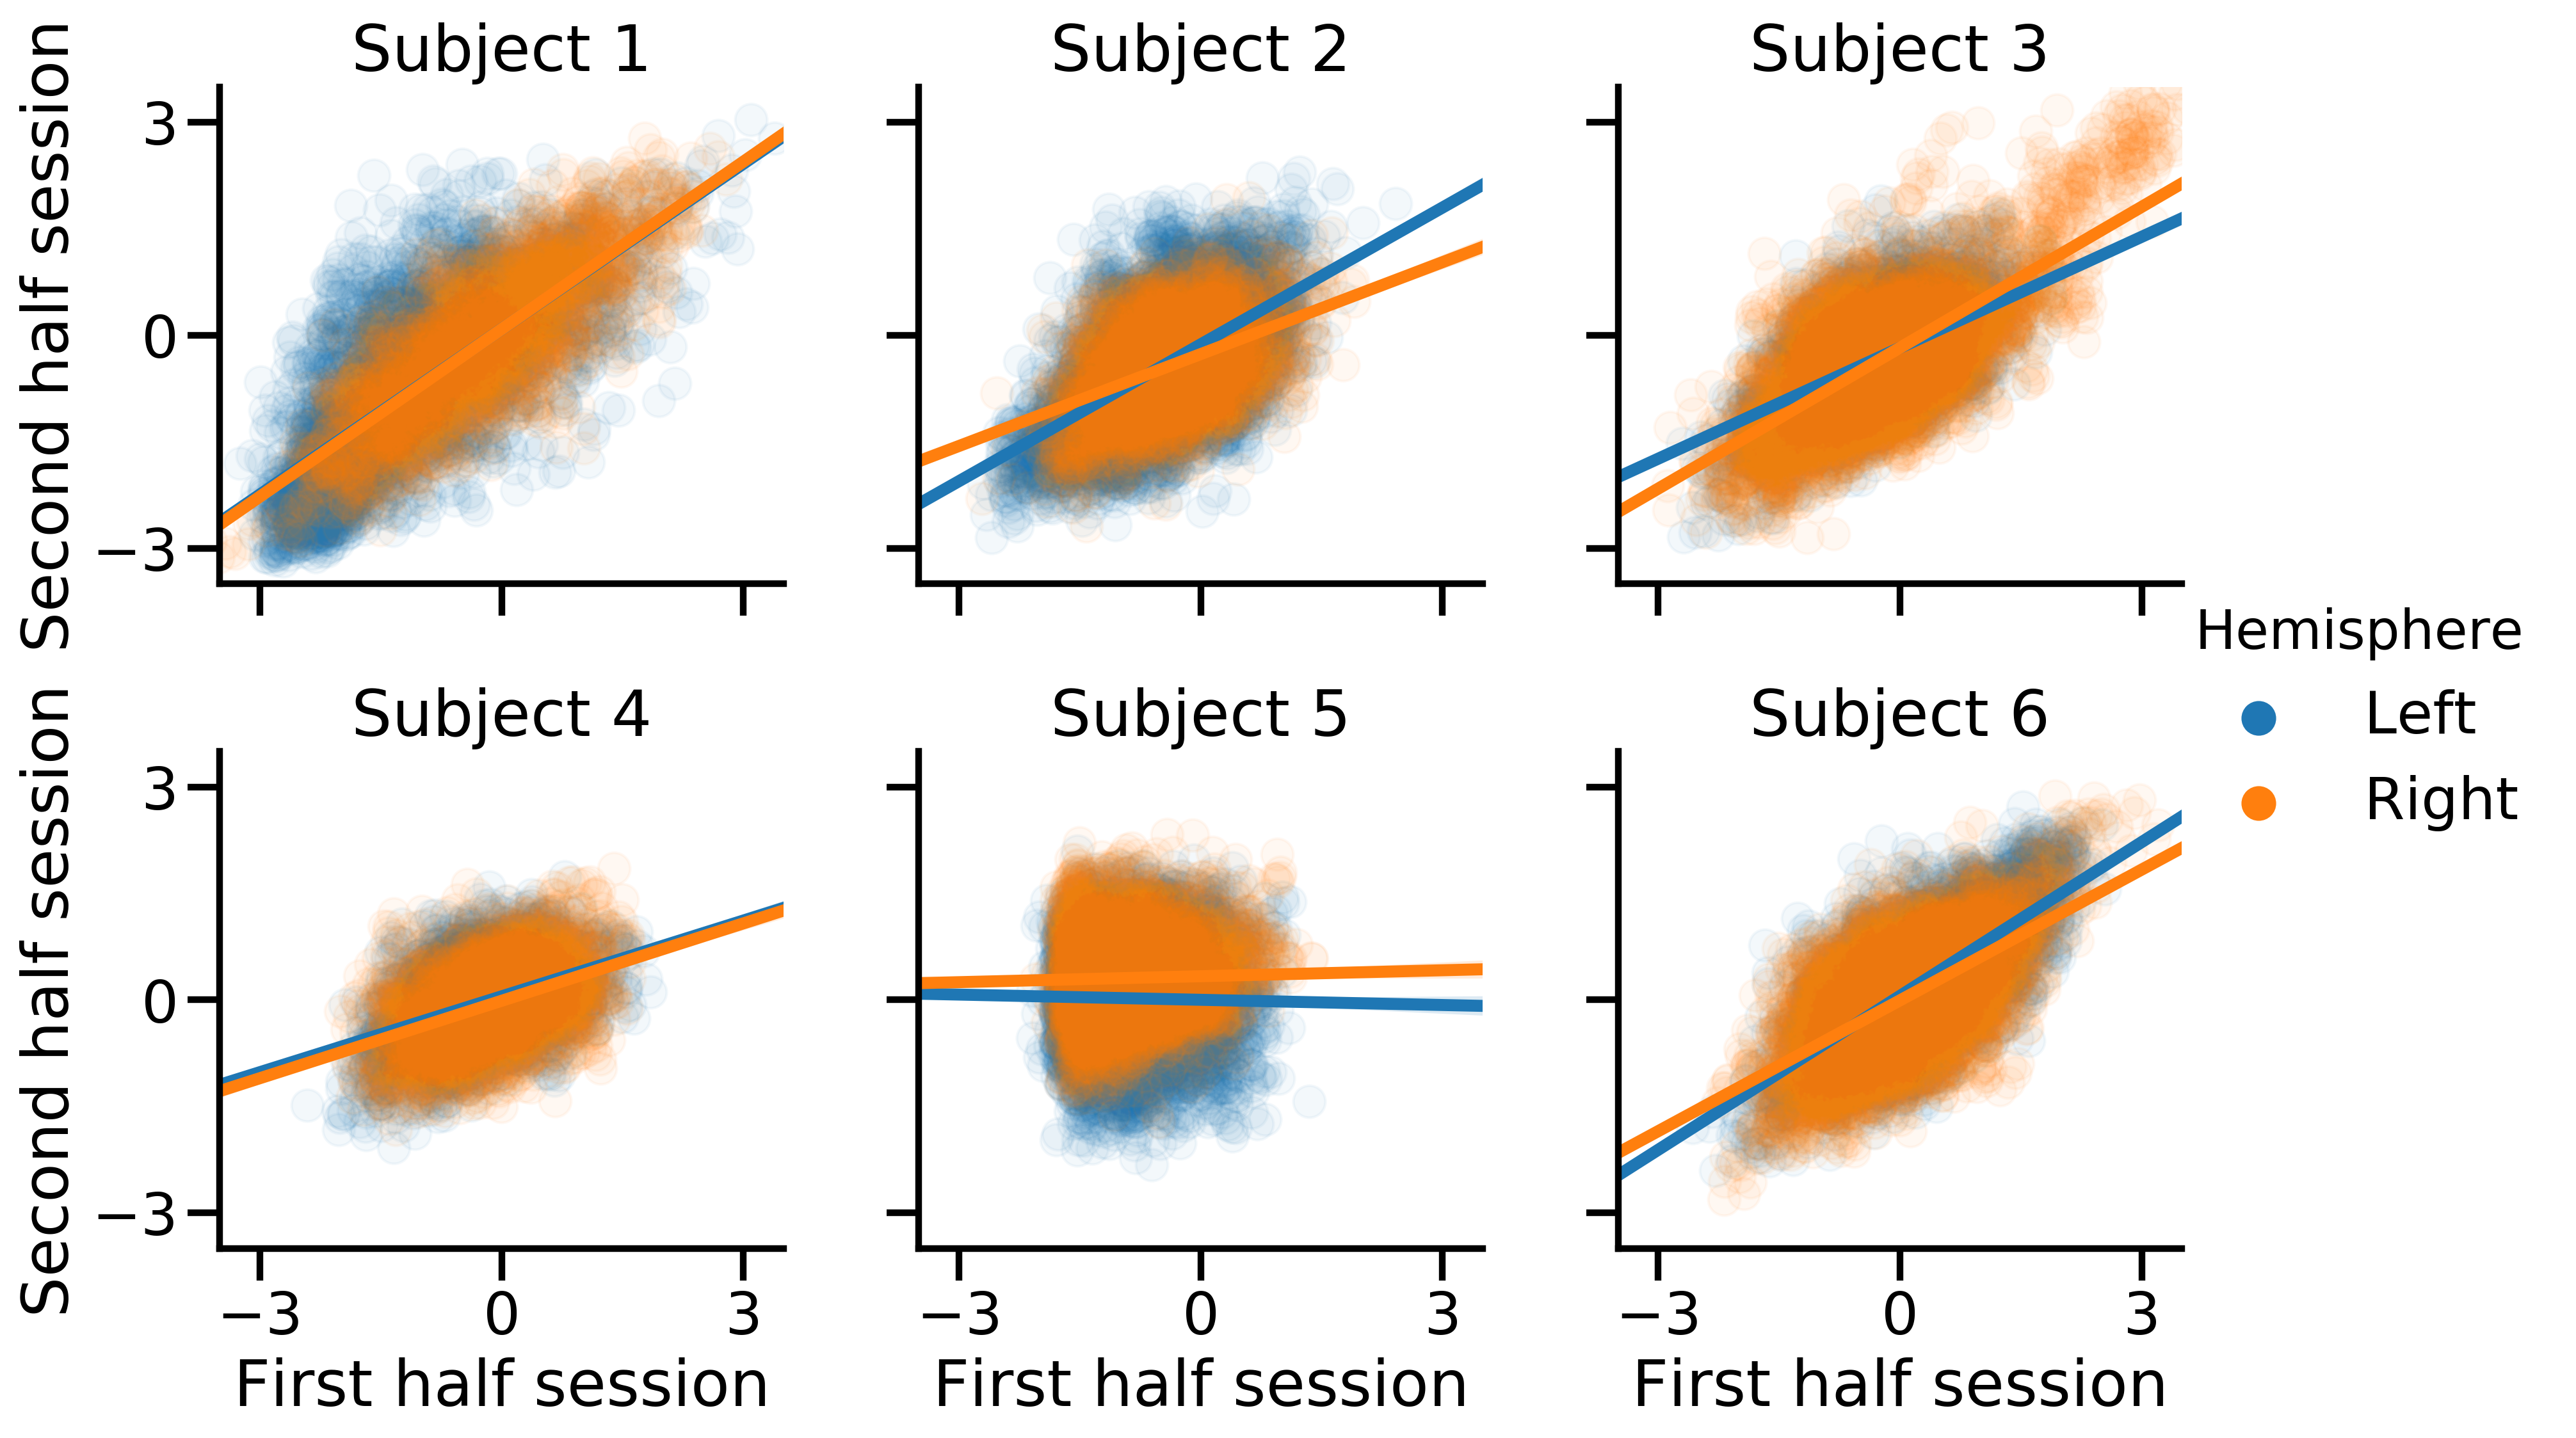

In [325]:
fac = sns.lmplot('First half session', 'Second half session', df, 'Hemisphere', col='subject_', col_wrap=3, sharex=True, sharey=True, aspect=1.,
                truncate=False, scatter_kws={'alpha':.05, 'rasterized':True}, size=4.)
fac.set_titles('Subject {col_name}')
fac.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), xticks=range(-3, 4, 3), yticks=range(-3, 4, 3))

for lh in fac.fig.get_children()[-1].legendHandles:
    lh.set_alpha(1.0)

fac.fig.set_dpi(300)

# fac.ax.legend()
# leg = plt.legend()

# for lh in leg.legendHandles: 
#     lh._legmarker.set_alpha(1.0)

plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure2/across_subjects.pdf')


In [34]:
import scipy.stats as ss

In [36]:
rs = df.groupby(['subject', 'hemisphere']).apply(lambda d: ss.pearsonr(d['zmap1'], d['zmap2'])[0])
rs.head()

subject  hemisphere
bm       Left          0.716420
         Right         0.801522
de       Left          0.572809
         Right         0.441749
eo       Left          0.552403
dtype: float64

In [44]:
rs[~np.in1d(rs.index.get_level_values('subject'), ['ns'])].describe()

count    10.000000
mean      0.592539
std       0.135420
min       0.409936
25%       0.469413
50%       0.590334
75%       0.698326
max       0.801522
dtype: float64

In [58]:
df['same sign'] = np.sign(df['zmap1']) == np.sign(df['zmap2'])

In [66]:
same_sign = df.groupby(['subject', 'hemisphere']).mean()['same sign']

same_sign[~np.in1d(same_sign.index.get_level_values('subject'), ['ns'])].describe()

count    10.000000
mean      0.699155
std       0.058728
min       0.596662
25%       0.670101
50%       0.696921
75%       0.729948
max       0.787949
Name: same sign, dtype: float64

# Single subject

In [282]:
df2 = []

for subject, session in [('tk', 'odc2'),
                         ('tk', 'odc3'),
                         ('tk', 'cas')]:
    
    left, right = cortex.db.get_surf(f'odc.{subject}', 'fiducial')
    
    for hemi in ['lh', 'rh']:
        mask_str = 'V1{}'.format(hemi[:1])

        surf = glob.glob(f'/data/odc/derivatives/sampled_giis/sub-{subject}/ses-{session}/func/sub-{subject}_ses-{session}_left_over_right_desc-zmap-depth-*_hemi-{hemi}.gii')
        zmap = np.mean([surface.load_surf_data(s) for s in surf], 0)        
        mask = cortex.utils.get_roi_verts(f'odc.{subject}', mask_str)[mask_str]

        if hemi == 'rh':
            mask -= len(left[0])
            
        zmap = zmap[mask]

        d = pd.DataFrame({'zmap':zmap, 'subject':subject, 'hemi':hemi, 'session':session,
                          'vertex':mask})

        df2.append(d)        

In [283]:
df2 = pd.concat(df2)

In [284]:
df2 = df2.pivot_table(index=['subject', 'hemi', 'vertex'], columns='session', values='zmap')

In [285]:
df2 = df2[~(df2 == 0).any(1)]

In [295]:
tmp1, tmp2, tmp3 = df2.copy(), df2.copy(), df2.copy()

tmp = pd.concat((tmp1, 
                 tmp2, 
                 tmp3),
                keys=[('Amsterdam 1', 'Amsterdam 2'), 
                      ('Amsterdam 1', 'Beijing'), 
                      ('Amsterdam 2', 'Beijing')],
               names=['Session 1', 'Session 2'])

In [296]:
tmp['Hemisphere'] = tmp.index.get_level_values('hemi').map({'lh':'Left', 'rh':'Right'})

tmp.loc[('Amsterdam 1'), 'zmap1']  = tmp['odc2']
tmp.loc[('Amsterdam 2'), 'zmap1']  = tmp['odc3']

tmp.loc[(slice(None), 'Amsterdam 2'), 'zmap2']  = tmp['odc3']
tmp.loc[(slice(None), 'Beijing'), 'zmap2']  = tmp['cas']

In [297]:
tmp['sessions'] = list(zip(tmp.index.get_level_values('Session 1'), tmp.index.get_level_values('Session 2')))

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


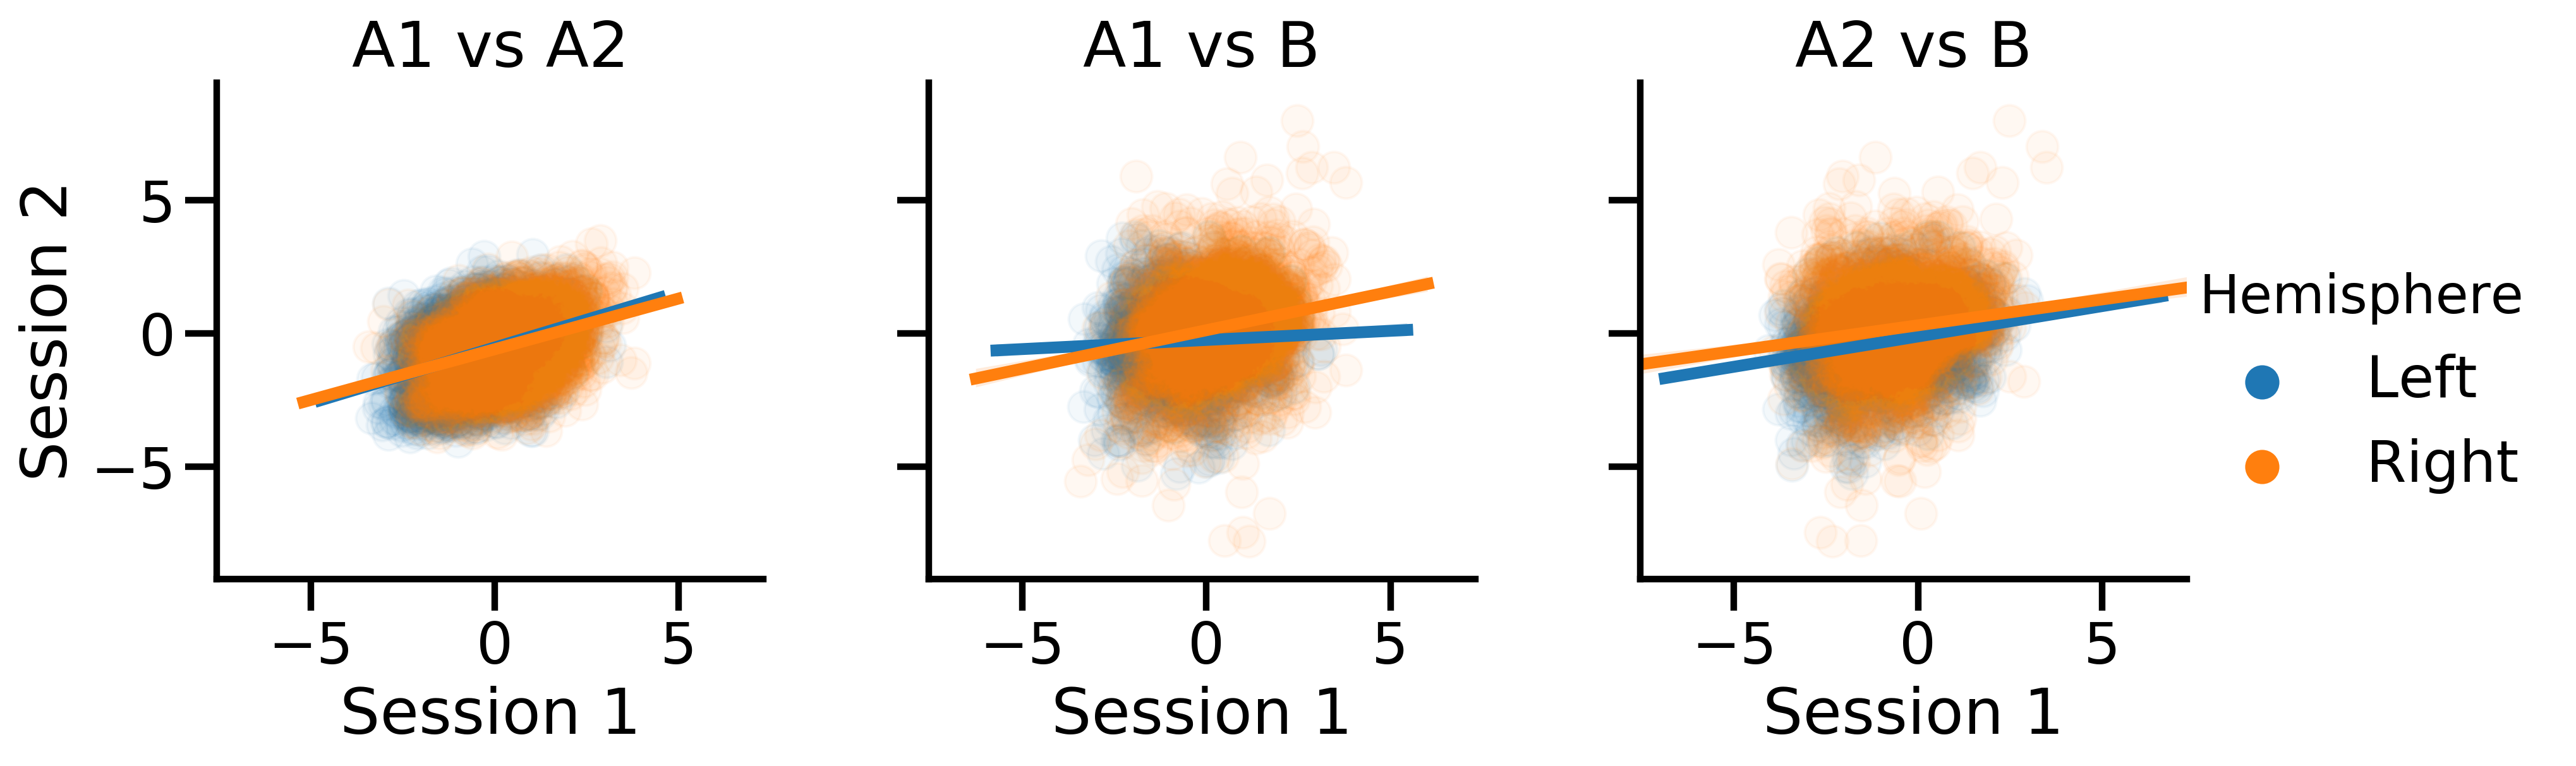

In [326]:
fac = sns.lmplot('zmap1', 'zmap2', 
                 tmp.reset_index(), 'Hemisphere', 
                 col='sessions', col_wrap=3, sharex=True, sharey=True,#, aspect=1.)
                 size=4.,
               truncate=False, scatter_kws={'alpha':.05, 'rasterized':True})
fac.set_titles('')

fac.set_xlabels('Session 1')
fac.set_ylabels('Session 2')

for lh in fac.fig.get_children()[-1].legendHandles:
    lh.set_alpha(1.0)

fac.axes[0].set_title('A1 vs A2')
fac.axes[1].set_title('A1 vs B')
fac.axes[2].set_title('A2 vs B')

fac.fig.set_dpi(300)


plt.savefig("/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure2/within_subject.pdf")

In [303]:
tmp.groupby(['Session 1', 'Session 2', 'Hemisphere']).apply(lambda d: ss.pearsonr(d['zmap1'], d['zmap2'])[0]).to_frame('r').T

Session 1  Amsterdam 1                               Amsterdam 2          
Session 2  Amsterdam 2             Beijing               Beijing          
Hemisphere        Left     Right      Left     Right        Left     Right
r             0.355047  0.363914  0.060237  0.217123    0.235605  0.152806

In [304]:
tmp['same sign'] = np.sign(tmp['zmap1']) == np.sign(tmp['zmap2'])

In [307]:
tmp.groupby(['Session 1', 'Session 2', 'Hemisphere']).mean()[['same sign']]

session                             same sign
Session 1   Session 2   Hemisphere           
Amsterdam 1 Amsterdam 2 Left         0.653595
                        Right        0.571707
            Beijing     Left         0.558652
                        Right        0.597048
Amsterdam 2 Beijing     Left         0.592707
                        Right        0.553049